In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
df_pasquet_train  = pd.read_csv("../data/SERSIC/df_pasquet_train.csv", dtype={'bestObjID': 'Int64', 'objID': 'Int64'})
df_pasquet_all  = pd.read_csv("../data/SERSIC/df_pasquet.csv", dtype={'bestObjID': 'Int64', 'objID': 'Int64'})
df_train  = pd.read_csv("../data/SERSIC/df_train.csv", dtype={'bestObjID': 'Int64', 'objID': 'Int64'})

In [25]:
X_pasquet = np.load("..\data\SERSIC\X_train_pasquet_augmented_x10.npz")
X_delight = np.load("..\data\SERSIC\X_train_augmented_x30.npz")

In [26]:
pos_pasquet = X_pasquet['pos']
pos_delight = X_delight['pos']

In [ ]:
distancias_pasquet = np.linalg.norm(pos_pasquet, axis=1)
distancias_delight = np.linalg.norm(pos_delight, axis=1)

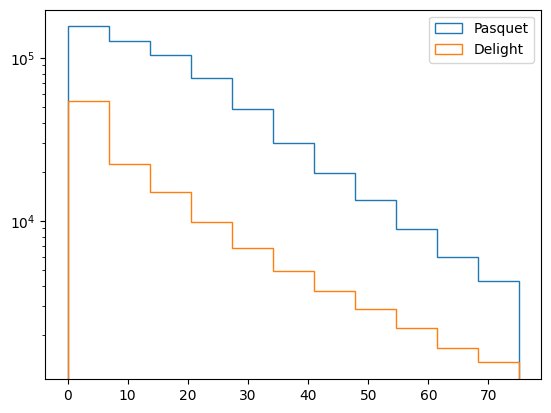

In [28]:
bins_arcsec = np.linspace(0, 300 * 0.25, 12)

plt.hist(distancias_pasquet, bins=bins_arcsec, label="Pasquet", histtype="step")
plt.hist(distancias_delight, bins=bins_arcsec, label="Delight", histtype="step")
plt.yscale("log")
plt.legend()
plt.show()

In [4]:
ser_radius = df_pasquet_all["rSerRadius"]
ser_radius_train = df_train["rSerRadius"]

In [5]:
def get_balance_mask(df, seed=0, scale="linear"):

    df = df.copy()
    n=12
    bins_arcsec = np.linspace(0,300*0.25,n)

    df['bin'] = pd.cut(df['rSerRadius'] * 3, bins=bins_arcsec, right=False)
    df['bin'] = df['bin'].astype(object)

    # Extraer límite izquierdo de cada bin
    df['bin_left'] = df['bin'].map(lambda x: x.left if pd.notnull(x) else np.nan)

    # Crear máscara inicial
    mask = pd.Series(False, index=df.index)

    # Bins < 40 → ordenar e interpolar de 10% a 50%
    bins_lt_40 = df[df['bin_left'] < 40]['bin'].dropna().unique()
    bins_lt_40 = sorted(bins_lt_40, key=lambda x: x.left)  # ordenarlos por el límite izquierdo

    n_bins = len(bins_lt_40)
    if scale=="linear":
        fracs = np.linspace(0.05, 0.5, n_bins)  
    else:
        fracs = np.logspace(np.log10(0.01), np.log10(0.5), n_bins)

    for bin_i, frac in zip(bins_lt_40, fracs):
        df_bin = df[df['bin'] == bin_i]
        n_samples = int(len(df_bin) * frac)
        sampled_idx = df_bin.sample(n=n_samples, replace=False, random_state=seed).index
        mask.loc[sampled_idx] = True

    # Bins >= 40 → conservar todos
    mask.loc[df[df['bin_left'] >= 40].index] = True

    return mask

In [7]:
linear_mask = get_balance_mask(df_pasquet_all, scale='linear')
log_mask = get_balance_mask(df_pasquet_all, scale='log')

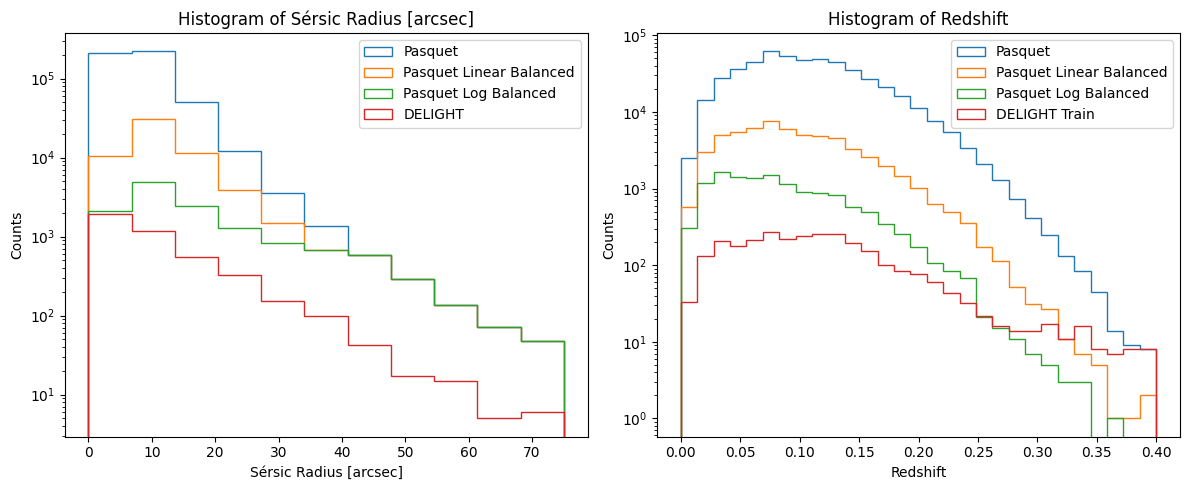

In [24]:
bins_arcsec = np.linspace(0, 300 * 0.25, 12)
bins_z = np.linspace(0, 0.4, 30)


fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False)

# Primer subplot: Histogramas de radios
axes[0].hist(ser_radius * 3, bins=bins_arcsec, histtype="step", label="Pasquet", color='C0')
axes[0].hist(ser_radius[linear_mask] * 3, bins=bins_arcsec, histtype="step", label="Pasquet Linear Balanced", color='C1')
axes[0].hist(ser_radius[log_mask] * 3, bins=bins_arcsec, histtype="step", label="Pasquet Log Balanced", color='C2')
axes[0].hist(ser_radius_train * 3, bins=bins_arcsec, histtype="step", label="DELIGHT", color='C3')

axes[0].set_xlabel("Sérsic Radius [arcsec]")
axes[0].set_ylabel("Counts")
axes[0].set_yscale("log")
axes[0].set_title("Histogram of Sérsic Radius [arcsec]")
axes[0].legend()

# Segundo subplot: Histogramas de redshift
axes[1].hist(df_pasquet_all["z"], bins=bins_z, histtype="step", label="Pasquet", color='C0')
axes[1].hist(df_pasquet_all["z"][linear_mask], bins=bins_z, histtype="step", label="Pasquet Linear Balanced", color='C1')
axes[1].hist(df_pasquet_all["z"][log_mask], bins=bins_z, histtype="step", label="Pasquet Log Balanced", color='C2')
axes[1].hist(df_train['host_redshift'], bins=bins_z, histtype="step", label="DELIGHT Train", color='C3')

axes[1].set_xlabel("Redshift")
axes[1].set_ylabel("Counts")
axes[1].set_yscale("log")
axes[1].set_title("Histogram of Redshift")
axes[1].legend()

plt.tight_layout()
plt.show()